In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [7]:
df = pd.read_excel(
    "/data02/gtguo/DEL/data/002-CAIX/ja9b01203_si_002.xlsx", sheet_name="D6")
data = df.loc[:, ["scaffold", "BB1", "BB2", "hrp_beads_r1", "hrp_beads_r2", "hrp_beads_r3", "hrp_beads_r4",
                "hrp_exp_r1", "hrp_exp_r2", "ca9_beads_r1", "ca9_beads_r2", "ca9_exp_r1", "ca9_exp_r2", "ca9_exp_r3", "ca9_exp_r4"]].to_dict()


(array([7.2581e+04, 2.1122e+04, 6.8970e+03, 4.2890e+03, 1.6640e+03,
        6.2700e+02, 4.2800e+02, 2.4700e+02, 1.1900e+02, 1.1200e+02,
        8.9000e+01, 6.3000e+01, 4.3000e+01, 5.1000e+01, 2.4000e+01,
        3.4000e+01, 3.3000e+01, 1.2000e+01, 2.5000e+01, 1.0000e+01,
        7.0000e+00, 9.0000e+00, 7.0000e+00, 2.0000e+00, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.  ,   3.66,   7.32,  10.98,  14.64,  18.3 ,  21.96,  25.62,
         29.28,  32.94,  36.6 ,  40.26,  43.92,  47.58,  51.24,  54.9 ,
         58.56,  62.22,  65.88,  69.54,  73.2 ,  76.86,  80.52,  84.18,
         87.84,  91.5 ,  95.16,  98.82, 102.48, 106.14, 109.8 , 113.46,
        117.12, 120.78, 124.44

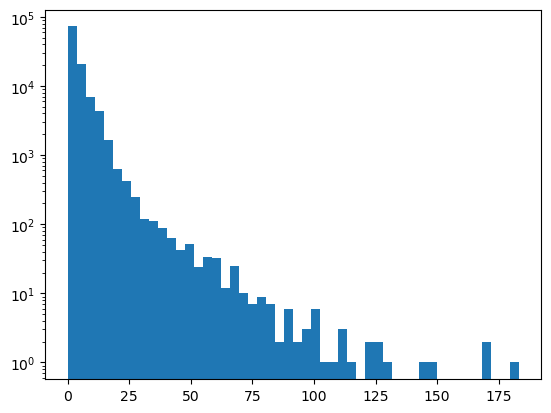

In [13]:
counts_dict = data["ca9_exp_r1"]
bb1, bb2, bb3 = data["scaffold"], data["BB1"], data["BB2"]

plt.yscale("log")
plt.hist(list(counts_dict.values()), bins=50)

In [18]:
import lmdb
import pickle

env = lmdb.open("/data02/gtguo/DEL/data/dataset/acs.jcim.2c01608/bbsmiles", map_size=1099511627776)
txn = env.begin()
print(pickle.loads(txn.get("0".encode()))[0])

{1: 'O=C(NC)[C@@H]1N(C(OC(C)(C)C)=O)CC[C@@H]1C2=CC=C(I)C=C2', 2: 'O=C(NC)[C@H]1N(C(OC(C)(C)C)=O)CC[C@H]1C2=CC=C(I)C=C2', 3: 'O=C(NC)[C@@H]1N(C(OC(C)(C)C)=O)C[C@@H]1C2=CC=C(I)C=C2', 4: 'O=C(NC)[C@@H]1N(C(OC(C)(C)C)=O)C[C@H]1C2=CC=C(I)C=C2', 5: 'O=C(NC)[C@@H]1N(C(OC(C)(C)C)=O)CC[C@H]1C2=CC=C(I)C=C2', 6: 'O=C(NC)[C@H]1N(C(OC(C)(C)C)=O)C[C@H]1C2=CC=C(I)C=C2', 7: 'O=C(NC)[C@H]1N(C(OC(C)(C)C)=O)CC[C@@H]1C2=CC=C(I)C=C2', 8: 'O=C(NC)[C@H]1N(C(OC(C)(C)C)=O)C[C@@H]1C2=CC=C(I)C=C2'}


In [27]:
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher
import copy
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover

In [8]:
G1 = nx.path_graph(4)
G2 = nx.path_graph(3)
gm = nx.algorithms.isomorphism.GraphMatcher(G1, G2)
gm.subgraph_is_isomorphic()

True

In [10]:
G1 = nx.path_graph(4)
G2 = nx.path_graph(4)
G2.add_edge(3, 0)
gm = nx.algorithms.isomorphism.GraphMatcher(G2, G1)
gm.subgraph_is_isomorphic()

False

In [28]:
def smiles_to_mol_graph(smiles: str) -> nx.Graph:
    """
    Transform a SMILES string to a molecular graph
    """
    if smiles == "":
        print("Empty SMILES string")
        return nx.Graph()

    mol = Chem.MolFromSmiles(smiles)

    remover = SaltRemover()
    mol = remover.StripMol(mol)

    mol_graph = nx.Graph()
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_symbol = atom.GetSymbol()
        mol_graph.add_node(atom_idx, atom_symbol=atom_symbol)
    for bond in mol.GetBonds():
        atom1_idx = bond.GetBeginAtomIdx()
        atom2_idx = bond.GetEndAtomIdx()
        # TODO maybe useful to consider passing rdkit bondtype afterwards
        bond_type = str(bond.GetBondType())
        mol_graph.add_edge(atom1_idx, atom2_idx, bond_type=bond_type)
    return mol_graph

def reduce_graph_to_core(mol_graph: nx.Graph) -> nx.Graph:
    """
    Keep reducing the molecular graph, until:
    1. The graph contains only one atom
    2. The graph contains a diatomic chain
    3. The graph is made of rings and linkers
    """
    core_graph = copy.deepcopy(mol_graph)
    while True:
        # get the atom indices of the peripheral atoms
        peripheral_atom_indices = [atom_idx for atom_idx in core_graph.nodes if len(
            list(core_graph.neighbors(atom_idx))) == 1]
        # no peripheral atoms means the graph is made of rings and linkers between rings
        if len(peripheral_atom_indices) == 0:
            return core_graph
        # single atom or diatomic chain
        elif len(peripheral_atom_indices) <= 2 and len(peripheral_atom_indices) == len(core_graph.nodes):
            return core_graph
        else:
            core_graph.remove_nodes_from(peripheral_atom_indices)


def expand_core_to_skeleton(
        bb_mol_graph: nx.Graph,
        core_of_bb_mol_graph: nx.Graph,
        template_mol_graph: nx.Graph
):
    def add_atom(mol_graph: nx.Graph, new_atom_idx: int, root_atom_idx: int, new_atom_symbol: str, bond_type: str) -> nx.Graph:
        mol_graph.add_node(new_atom_idx, atom_symbol=new_atom_symbol)
        mol_graph.add_edge(new_atom_idx, root_atom_idx, bond_type=bond_type)
        return mol_graph

    def r_branch_from_single_atom(
            atom_idx: int,
            current_graph: nx.Graph,
            bb_mol_graph: nx.Graph,
            template_mol_graph: nx.Graph,
            public_occupied_atom_indeces: list
    ):
        for neighbor in bb_mol_graph.neighbors(atom_idx):
            if neighbor in public_occupied_atom_indeces:
                continue
            branch_attempt_graph = copy.deepcopy(current_graph)
            branch_attempt_graph = add_atom(branch_attempt_graph, neighbor, atom_idx,
                                            bb_mol_graph.nodes[neighbor]["atom_symbol"], bb_mol_graph.edges[neighbor, atom_idx]["bond_type"])
            # check atom symbols only
            gm = nx.algorithms.isomorphism.GraphMatcher(
                template_mol_graph, branch_attempt_graph, node_match=lambda n1, n2: n1['atom_symbol'] == n2['atom_symbol'], edge_match=lambda e1, e2: e1['bond_type'] == e2['bond_type'])
            if gm.subgraph_is_isomorphic():
                public_occupied_atom_indeces.append(neighbor)
                current_graph = r_branch_from_single_atom(
                    neighbor, branch_attempt_graph, bb_mol_graph, template_mol_graph, public_occupied_atom_indeces)
            # else the current graph stays unchanged
        return current_graph

    public_occupied_atom_indeces = [
        atom_idx for atom_idx in core_of_bb_mol_graph.nodes]
    skeleton_of_bb_mol_graph = copy.deepcopy(core_of_bb_mol_graph)
    for core_atoms in core_of_bb_mol_graph.nodes:
        skeleton_of_bb_mol_graph = r_branch_from_single_atom(
            core_atoms, skeleton_of_bb_mol_graph, bb_mol_graph, template_mol_graph, public_occupied_atom_indeces)
    return skeleton_of_bb_mol_graph


def get_bb_skeleton(bb_mol_graph: nx.Graph, template_mol_graph: nx.Graph):
    # TODO: this method suits for reactions that do not form rings, need a template-based version soon, referring to J Chem Inf Model 2023, 63 (15), 4641-4653. SI.
    def expose_amide(mol_g: nx.Graph):
        g_copy = copy.deepcopy(mol_g)
        for atom_idx in mol_g.nodes:
            if mol_g.nodes[atom_idx]["atom_symbol"] != "N":
                continue
            for neighbor in mol_g.neighbors(atom_idx):
                if len([nn for nn in mol_g.neighbors(neighbor)]) > 1:
                    continue
                g_copy.remove_edge(neighbor, atom_idx)
                g_copy.remove_node(neighbor)
        return g_copy

    core_of_bb_mol_graph = reduce_graph_to_core(bb_mol_graph)
    skeleton_of_bb_mol_graph = expand_core_to_skeleton(
        bb_mol_graph=bb_mol_graph, core_of_bb_mol_graph=core_of_bb_mol_graph, template_mol_graph=template_mol_graph)
    skeleton_of_bb_mol_graph = expose_amide(skeleton_of_bb_mol_graph)
    return skeleton_of_bb_mol_graph


def match_motif_to_mol(mol: nx.Graph, bb_motif_dict: dict[str, nx.Graph]) -> nx.Graph:
    def r_find_nearest_motif_assigned_neighbor(mol: nx.Graph, node_idx: int, visited: list[int]):
        cmol = copy.deepcopy(mol)
        visited.append(node_idx)
        passed_motif_list = []
        # iterate over neighbors to get motif information
        for neighbor_idx in cmol.neighbors(node_idx):
            if cmol.nodes[neighbor_idx]["motif"] is not None:
                passed_motif = cmol.nodes[neighbor_idx]["motif"]
            # if the neighbor is not motif-assigned and not visited, recursively find the motif
            elif neighbor_idx not in visited:
                cmol, passed_motif = r_find_nearest_motif_assigned_neighbor(
                    cmol, neighbor_idx, visited)
            # prevent infinite loop
            else:
                continue
            passed_motif_list.append(passed_motif)
        passed_motif_list = np.unique(passed_motif_list)

        if len(passed_motif_list) > 1:
            motif_to_be_assigned = min(passed_motif_list)
            # warn(f"Node {node_idx} has more than one motif-assigned neighbor, only the smallest one {motif_to_be_assigned} is considered")
        else:
            motif_to_be_assigned = passed_motif_list[0]

        cmol.nodes[node_idx]["motif"] = motif_to_be_assigned
        return cmol, motif_to_be_assigned

    mol_copy = copy.deepcopy(mol)
    idx_wo_motif = list(mol_copy.nodes)
    for node_idx in mol_copy.nodes:
        mol_copy.nodes[node_idx]["motif"] = None

    for motif_name, motif in bb_motif_dict.items():
        gm = GraphMatcher(mol_copy, motif, node_match=lambda n1,
                          n2: n1['atom_symbol'] == n2['atom_symbol'] and n1['motif'] is None, edge_match=lambda e1, e2: e1['bond_type'] == e2['bond_type'])
        if not gm.subgraph_is_isomorphic():
            # TODO push re-examining request
            raise ValueError(
                f"Motif {motif_name} is not found in the molecule")
        for node_idx in gm.mapping.keys():
            mol_copy.nodes[node_idx]["motif"] = motif_name
            idx_wo_motif.remove(node_idx)

    for node_idx in idx_wo_motif:
        mol_copy, _ = r_find_nearest_motif_assigned_neighbor(
            mol_copy, node_idx, [])
    return mol_copy

In [29]:
bb_mol_graph = smiles_to_mol_graph(
    'O=C(NC)[C@@H]1N(C(OC(C)(C)C)=O)CC[C@@H]1C2=CC=C(I)C=C2')
bb2_mol_graph = smiles_to_mol_graph(
    "O=Cc1cc(ccc1)C#C")
bb3_mol_graph = smiles_to_mol_graph(
    "B(O)(O)c1c([nH]nc1)C.Cl"
)
template_mol_graph = smiles_to_mol_graph(
    "CNC(=O)[C@H]1[C@H](CCN1Cc2cccc(c2)C#C)c3ccc(cc3)c4cn[nH]c4C")
core_mol_graph = reduce_graph_to_core(bb_mol_graph)
skeleton_mol_graph = get_bb_skeleton(bb_mol_graph, template_mol_graph)

matched_mol_graph = match_motif_to_mol(template_mol_graph, {
                                       "1": skeleton_mol_graph, 
                                       "2": get_bb_skeleton(smiles_to_mol_graph("O=CC(C)(C)c1ccccc1"), template_mol_graph),
                                       "3": get_bb_skeleton(smiles_to_mol_graph("B(O)(O)c1c2[o]ccc2ccc1"), template_mol_graph)
                                       })


ValueError: Motif 2 is not found in the molecule

In [17]:
def draw_mol_graph(mol_graph: nx.Graph):
    pos = nx.spring_layout(mol_graph)
    nx.draw(mol_graph, pos)
    node_labels = nx.get_node_attributes(mol_graph, "atom_symbol")
    nx.draw_networkx_labels(mol_graph, pos, node_labels)
    edge_labels = nx.get_edge_attributes(mol_graph, "bond_type")
    nx.draw_networkx_edge_labels(mol_graph, pos, edge_labels)

def draw_colored_mol_graph(mol_graph: nx.Graph):
    color_dict = {
        "1": 1.0,
        "2": 0.5,
        "3": 0
    }
    pos = nx.spring_layout(mol_graph)
    nx.draw(mol_graph, pos, cmap=plt.get_cmap('viridis'), node_color=[color_dict[mol_graph.nodes[idx]["motif"]] for idx in mol_graph.nodes])
    node_labels = nx.get_node_attributes(mol_graph, "atom_symbol")
    nx.draw_networkx_labels(mol_graph, pos, node_labels)
    edge_labels = nx.get_edge_attributes(mol_graph, "bond_type")
    nx.draw_networkx_edge_labels(mol_graph, pos, edge_labels)

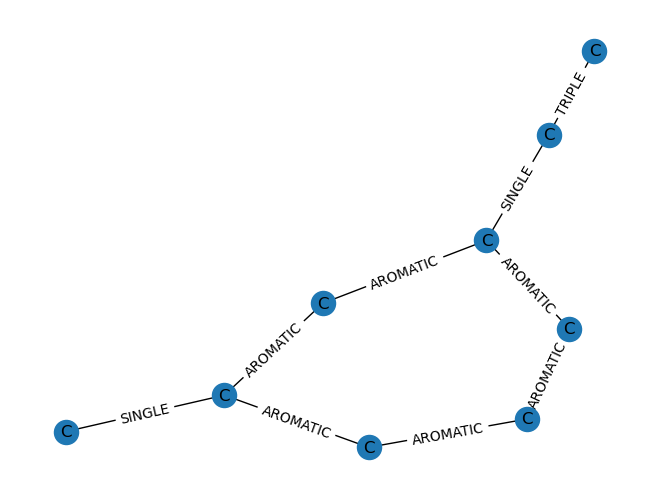

In [20]:
draw_mol_graph(get_bb_skeleton(bb2_mol_graph, template_mol_graph))

In [24]:
Draw.MolToFile(Chem.MolFromSmiles("B(O)(O)c1c([nH]nc1)C.Cl"), "test_2_bb3_49.png")

In [101]:
gm = nx.algorithms.isomorphism.GraphMatcher(template_mol_graph, get_bb_skeleton(bb2_mol_graph, template_mol_graph), node_match=lambda n1, n2: n1['atom_symbol']==n2['atom_symbol'], edge_match=lambda e1, e2: e1['bond_type']==e2['bond_type'])
gm.subgraph_is_isomorphic()
gm.mapping

{13: 5, 18: 6, 17: 7, 16: 8, 15: 9, 14: 10, 10: 2, 9: 1, 11: 3, 12: 4}

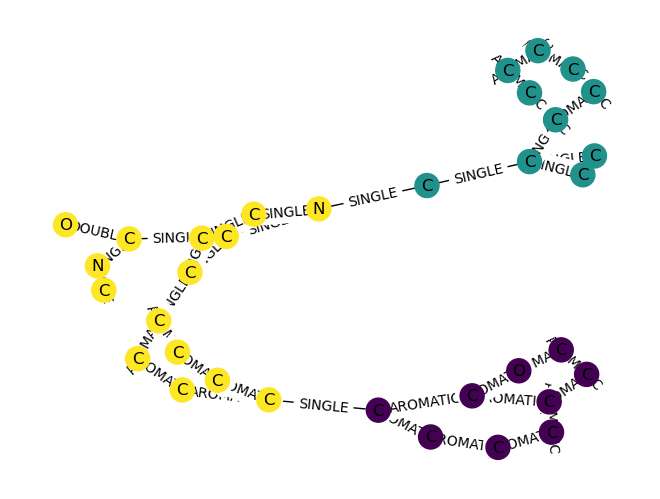

In [13]:
draw_colored_mol_graph(matched_mol_graph)


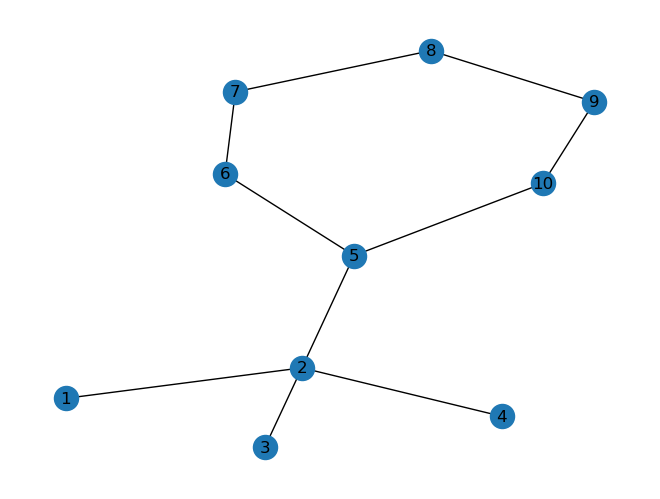

In [103]:
nx.draw(get_bb_skeleton(bb2_mol_graph, template_mol_graph), with_labels=True)

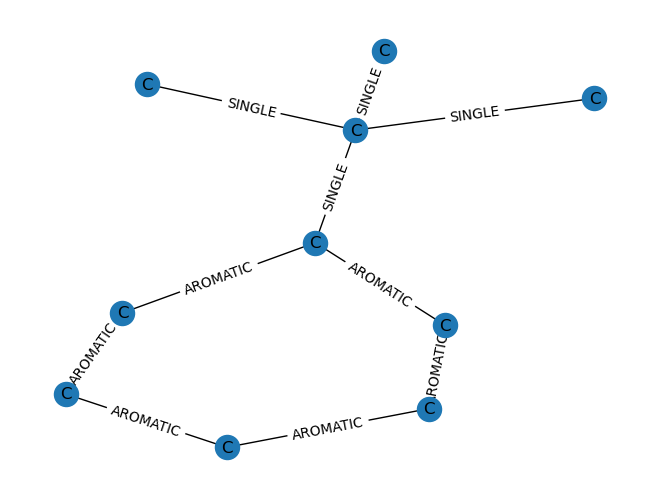

In [104]:
draw_mol_graph(get_bb_skeleton(bb2_mol_graph, template_mol_graph))

In [79]:
Draw.MolToFile(Chem.MolFromSmiles("O=CC(C)(C)c1ccccc1"), "test_bb2.png")

In [71]:
gm = nx.algorithms.isomorphism.GraphMatcher(template_mol_graph, skeleton_mol_graph, node_match=lambda n1,n2:n1['atom_symbol']==n2['atom_symbol'])
gm.subgraph_is_isomorphic()
gm.mapping

{4: 4,
 8: 5,
 7: 13,
 6: 14,
 5: 15,
 19: 16,
 24: 17,
 23: 18,
 22: 19,
 21: 21,
 20: 22,
 2: 1,
 3: 0,
 1: 2}

In [72]:
np.unique([1, 1, 2, 2, 3])

array([1, 2, 3])